# Students grades analysis 

**Add required imports**

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_theme(context='notebook', palette='pastel', style='whitegrid')

**Explore the data**

In [60]:
students_data = pd.read_csv('./students-data.csv')
students_data.drop(['GPA','StudentID'],axis =1,inplace=True)
students_data.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GradeClass
0,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.0
1,18,0,0,1,15.408756,0,0,1,0,0,0,0,1.0
2,15,0,2,3,4.210570,26,0,2,0,0,0,0,4.0
3,17,1,0,3,10.028829,14,0,3,1,0,0,0,3.0
4,17,1,0,2,4.672495,17,1,3,0,0,0,0,4.0


In [61]:
students_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2392 non-null   int64  
 1   Gender             2392 non-null   int64  
 2   Ethnicity          2392 non-null   int64  
 3   ParentalEducation  2392 non-null   int64  
 4   StudyTimeWeekly    2392 non-null   float64
 5   Absences           2392 non-null   int64  
 6   Tutoring           2392 non-null   int64  
 7   ParentalSupport    2392 non-null   int64  
 8   Extracurricular    2392 non-null   int64  
 9   Sports             2392 non-null   int64  
 10  Music              2392 non-null   int64  
 11  Volunteering       2392 non-null   int64  
 12  GradeClass         2392 non-null   float64
dtypes: float64(2), int64(11)
memory usage: 243.1 KB


In [62]:
students_data['GradeClass'].value_counts()

GradeClass
4.0    1211
3.0     414
2.0     391
1.0     269
0.0     107
Name: count, dtype: int64

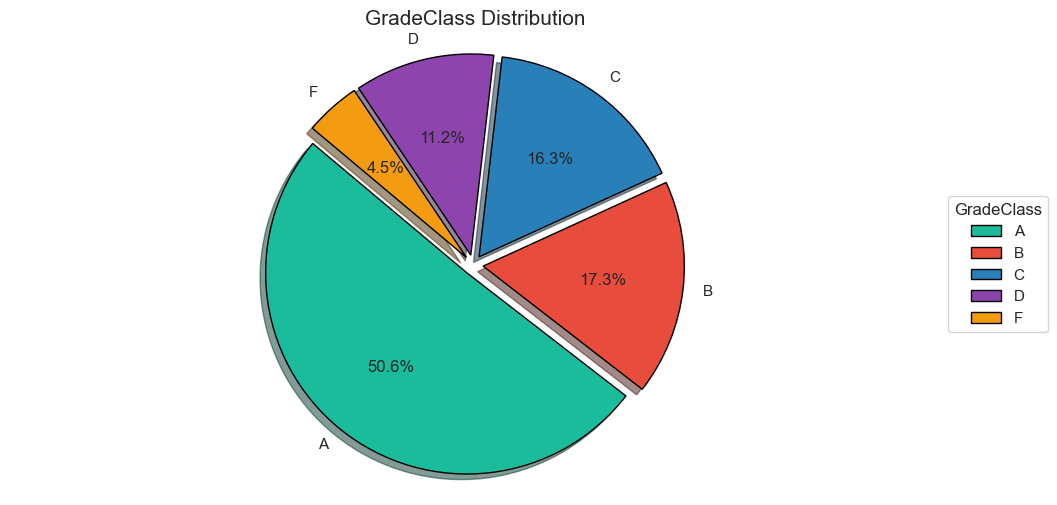

In [63]:
grade_counts = students_data['GradeClass'].value_counts()
grades =['A','B','C','D','F']
counts = grade_counts.values.tolist()
total_counts = sum(counts)
percentages = [(count / total_counts) * 100 for count in counts]

colors = ['#1abc9c','#e74c3c','#2980b9','#8e44ad','#f39c12']
explode = [0.05] * len(grades)  
plt.figure(figsize=(12, 6))
plt.pie(percentages, labels=grades, colors=colors, autopct='%1.1f%%', startangle=140, 
        shadow=True, explode=explode, wedgeprops={'edgecolor': 'black'})

plt.legend(grades, title="GradeClass", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('GradeClass Distribution', fontsize=15)
plt.axis('equal') 

plt.show()

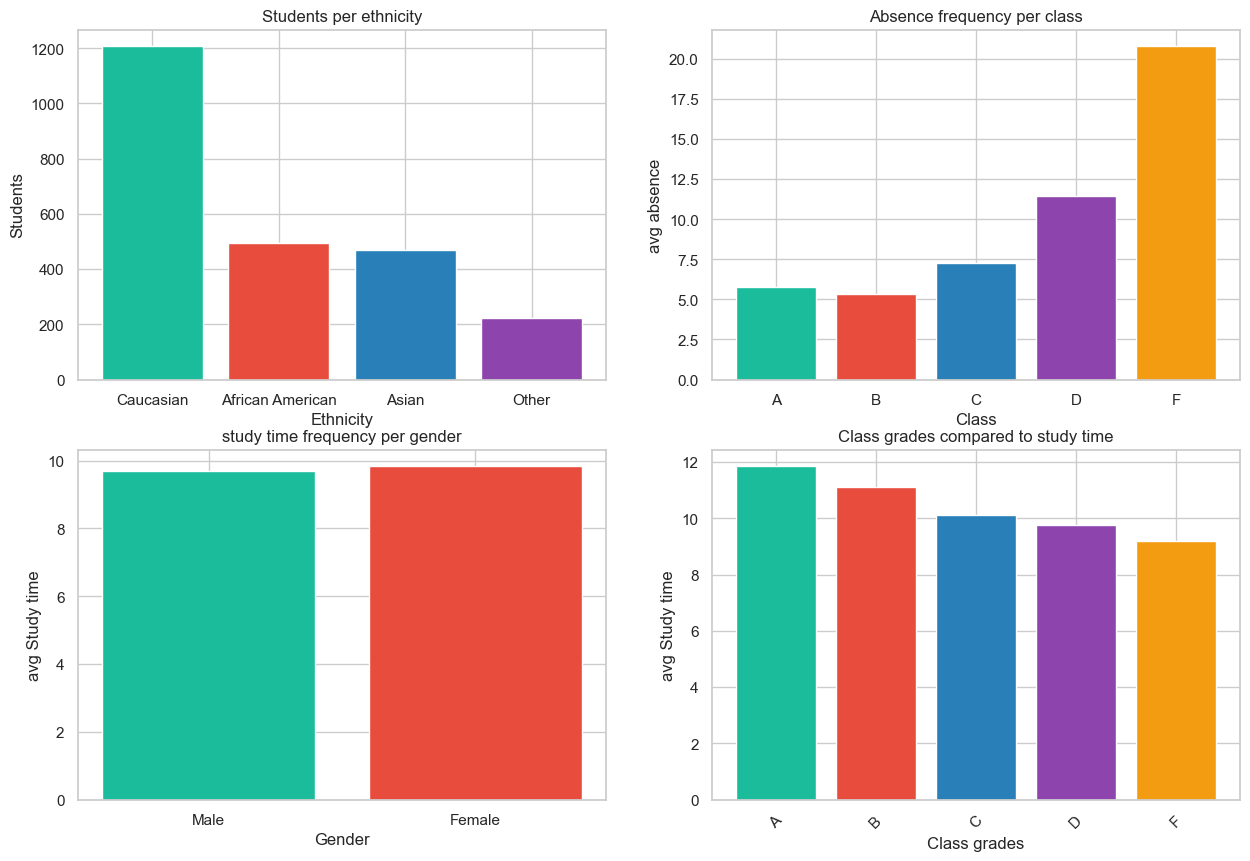

In [64]:
ethnicity_mapping = {
    0: 'Caucasian',
    1: 'African American',
    2: 'Asian',
    3: 'Other'
}
grades = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'F',
}

education_labels = {
    0: 'None',
    1: 'High School',
    2: 'Some College',
    3: "Bachelor's",
    4: 'Higher'
} 

ethnicities = [ethnicity_mapping[val] for val in students_data['Ethnicity']]
eth_df = pd.DataFrame(ethnicities, columns=['Ethnicity'])
ethnicity_counts = eth_df['Ethnicity'].value_counts()

abb_class = students_data[['GradeClass', 'Absences']].copy()
abb_class['GradeClassLabel'] = abb_class['GradeClass'].map(grades)
abb_class_show = abb_class.groupby('GradeClassLabel')['Absences'].mean()
abb_class_show

study_time_per_gender = students_data.groupby('Gender')['StudyTimeWeekly'].mean()

study_time_per_grade = students_data.groupby('GradeClass')['StudyTimeWeekly'].mean()

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(
    nrows = 2,
    ncols = 2,
    figsize = (15,10),

)

ax1.bar(ethnicity_counts.keys(),ethnicity_counts, color = ['#1abc9c','#e74c3c','#2980b9','#8e44ad','#f39c12'])
ax1.set(
    title = "Students per ethnicity",
    ylabel = 'Students',
    xlabel = 'Ethnicity',
)

ax2.bar(abb_class_show.keys(),abb_class_show , color = ['#1abc9c','#e74c3c','#2980b9','#8e44ad','#f39c12'])
ax2.set(
    title = "Absence frequency per class",
    ylabel = 'avg absence',
    xlabel = 'Class'
)

ax3.bar(['Male','Female'],study_time_per_gender, color = ['#1abc9c','#e74c3c'])
ax3.set(
    title = "study time frequency per gender",
    ylabel = 'avg Study time',
    xlabel = 'Gender'
)

ax4.bar(grades.values(), study_time_per_grade, color = ['#1abc9c','#e74c3c','#2980b9','#8e44ad','#f39c12'])
ax4.set(
    title = "Class grades compared to study time",
    ylabel = 'avg Study time',
    xlabel = 'Class grades'
)

plt.xticks(rotation=45)
plt.show()


In [65]:
def evaluate_preds(y_true, y_preds):
    """
        Performs evaluation comparison on y_true labes vs y_pred labels
    """
    accuracy = accuracy_score(y_true,y_preds)
    precision = precision_score(y_true,y_preds)
    recall = recall_score(y_true,y_preds)
    f1 = f1_score(y_true,y_preds)
    metric_dict = {
        "accuracy": round(accuracy,2),
        "precision": round(precision,2),
        "recall": round(recall,2),
        "f1": round(f1,2),
    }
    print(f'accuracy: {accuracy * 100:.2f}%')
    print(f'precision: {precision * 100:.2f}')
    print(f'recall: {recall * 100:.2f}')
    print(f'f1: {f1 * 100:.2f}')
    return metric_dict

In [66]:
students_data.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GradeClass
0,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.0
1,18,0,0,1,15.408756,0,0,1,0,0,0,0,1.0
2,15,0,2,3,4.210570,26,0,2,0,0,0,0,4.0
3,17,1,0,3,10.028829,14,0,3,1,0,0,0,3.0
4,17,1,0,2,4.672495,17,1,3,0,0,0,0,4.0


Decision Tree accuracy: 0.63
Random Forest accuracy: 0.68
Gradient Boosting accuracy: 0.70
AdaBoost accuracy: 0.61
K-Nearest Neighbors accuracy: 0.57
Logistic Regression accuracy: 0.68
SGD Classifier accuracy: 0.61
Support Vector Machine accuracy: 0.67
XGBoost accuracy: 0.69
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 12
[LightGBM] [Info] Start training from score -3.113777
[LightGBM] [Info] Start training from score -2.162800
[LightGBM] [Info] Start training from score -1.832843
[LightGBM] [Info] Start training from score -1.763414
[LightGBM] [Info] Start training from score -0.675017
LightGBM accuracy: 0.70
Learning rate set to 0.081788
0:	learn: 1.4922004	total: 3.99ms	remaining: 3.99

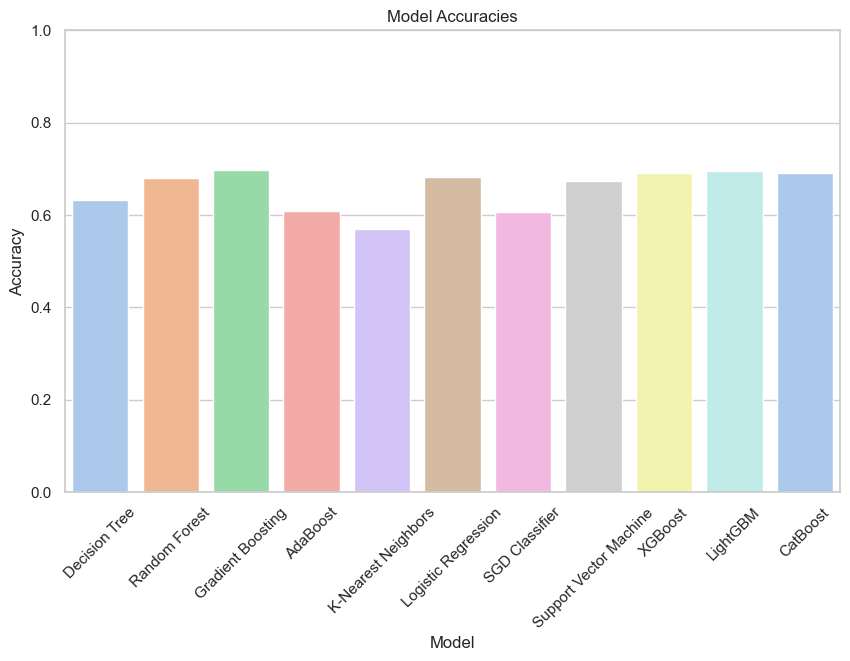

In [69]:

from sklearn.preprocessing import StandardScaler

models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SGD Classifier': SGDClassifier(),
    'Support Vector Machine': SVC(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier()
}

# Separate features (X) and target variable (y)
X = students_data.loc[:, students_data.columns != "GradeClass"]
y = students_data['GradeClass']

# Standardize the features using StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(X)

# Transform the data
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model_names = []
accuracies = []

# Train and evaluate each model
for name, clf in models.items():
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    model_names.append(name)
    accuracies.append(score)
    print(f"{name} accuracy: {score:.2f}")

# Create a DataFrame for model accuracies
df_models = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# Plot model accuracies using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df_models, palette='pastel')
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

In [70]:
df_models

,Model,Accuracy
0,Decision Tree,0.632568
1,Random Forest,0.680585
2,Gradient Boosting,0.697286
3,AdaBoost,0.609603
4,K-Nearest Neighbors,0.569937
5,Logistic Regression,0.682672
6,SGD Classifier,0.605428
7,Support Vector Machine,0.674322
8,XGBoost,0.691023
9,LightGBM,0.695198


In [1]:
# Define your chosen model
model = CatBoostClassifier(verbose=0)

# Define parameter grid for GridSearchCV
param_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.1, 0.01],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
}

# Perform GridSearchCV with 5-fold cross-validation 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Train the GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# Use the best model found by GridSearchCV for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print accuracy and F1-score on test set
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


NameError: name 'CatBoostClassifier' is not defined